In [2]:
# =====================================================
# 1. 데이터 로드
# =====================================================

# 라이브러리 불러오기
import pandas as pd
import numpy as np
import random

# 랜덤 시드 고정 (재현성 확보)
np.random.seed(1234)  # numpy용 시드
random.seed(1234)     # random용 시드

# 데이터 불러오기
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# 데이터 크기 확인
print("Train 데이터 크기:", train_df.shape)
print("Test 데이터 크기:", test_df.shape)


Train 데이터 크기: (891, 12)
Test 데이터 크기: (418, 11)


In [3]:
# =====================================================
# 2. 탐색적 데이터 분석 (EDA)
# =====================================================

# 출력 설정 (컬럼/행 개수)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# 데이터 상위 10개 확인
print(train_df.head(10))
print(test_df.head(10))

# 데이터 타입 확인
print(train_df.dtypes)

# 데이터 요약 통계 확인
print(train_df.describe())
print(test_df.describe())

# 범주형 변수 분포 확인
print("Sex 분포:\n", train_df["Sex"].value_counts())
print("Embarked 분포:\n", train_df["Embarked"].value_counts())
print("Cabin 분포:\n", train_df["Cabin"].value_counts())

# 결측치 확인
print("Train 결측치:\n", train_df.isnull().sum())
print("Test 결측치:\n", test_df.isnull().sum())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


         PassengerId      survived_rate
Survived           0    1              
Embarked                               
C                 75   93      0.446429
Q                 47   30      0.610390
S                427  217      0.663043


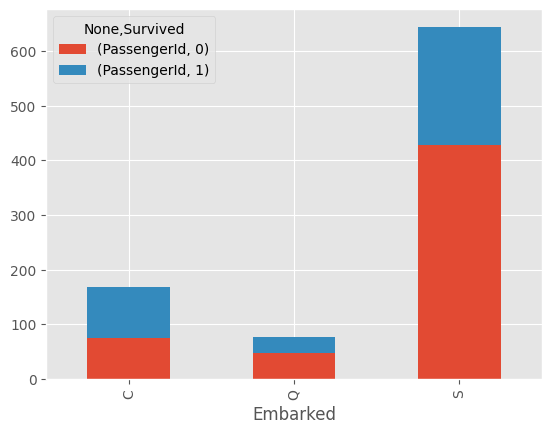

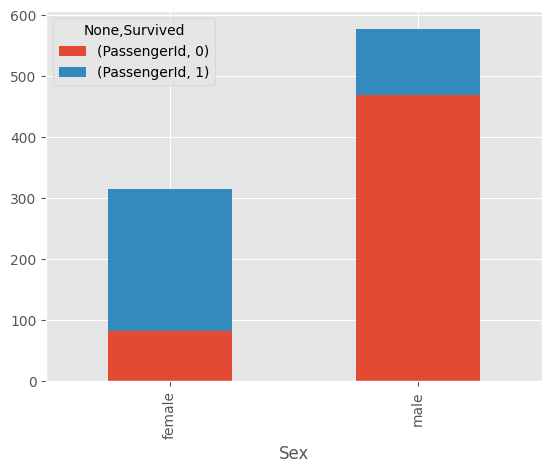

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


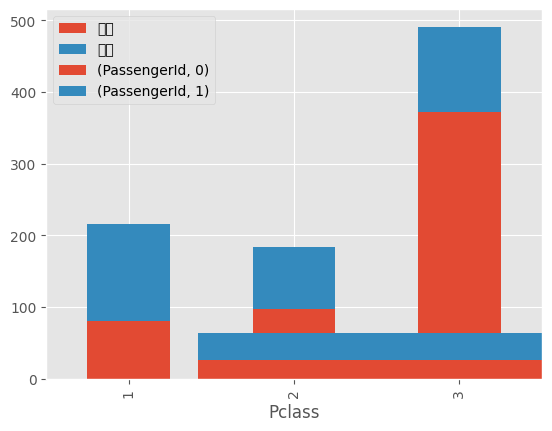

In [4]:
# =====================================================
# 데이터 시각화
# =====================================================
import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 설정
plt.style.use("ggplot")

# (1) Embarked별 생존자 수 시각화
embarked_df = train_df[["Embarked", "Survived", "PassengerId"]].dropna() \
    .groupby(["Embarked", "Survived"]).count().unstack()

embarked_df.plot.bar(stacked=True)
embarked_df["survived_rate"] = embarked_df.iloc[:, 0] / (embarked_df.iloc[:, 0] + embarked_df.iloc[:, 1])
print(embarked_df)

# (2) 성별 생존자 수 시각화
sex_df = train_df[["Sex", "Survived", "PassengerId"]].dropna() \
    .groupby(["Sex", "Survived"]).count().unstack()
sex_df.plot.bar(stacked=True)

# (3) Pclass별 생존자 수 시각화
ticket_df = train_df[["Pclass", "Survived", "PassengerId"]].dropna() \
    .groupby(["Pclass", "Survived"]).count().unstack()
ticket_df.plot.bar(stacked=True)

# (4) 나이별 생존자 분포 (히스토그램)
plt.hist(
    x=[train_df.Age[train_df.Survived == 0], train_df.Age[train_df.Survived == 1]],
    bins=8, histtype='barstacked', label=["사망", "생존"]
)
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


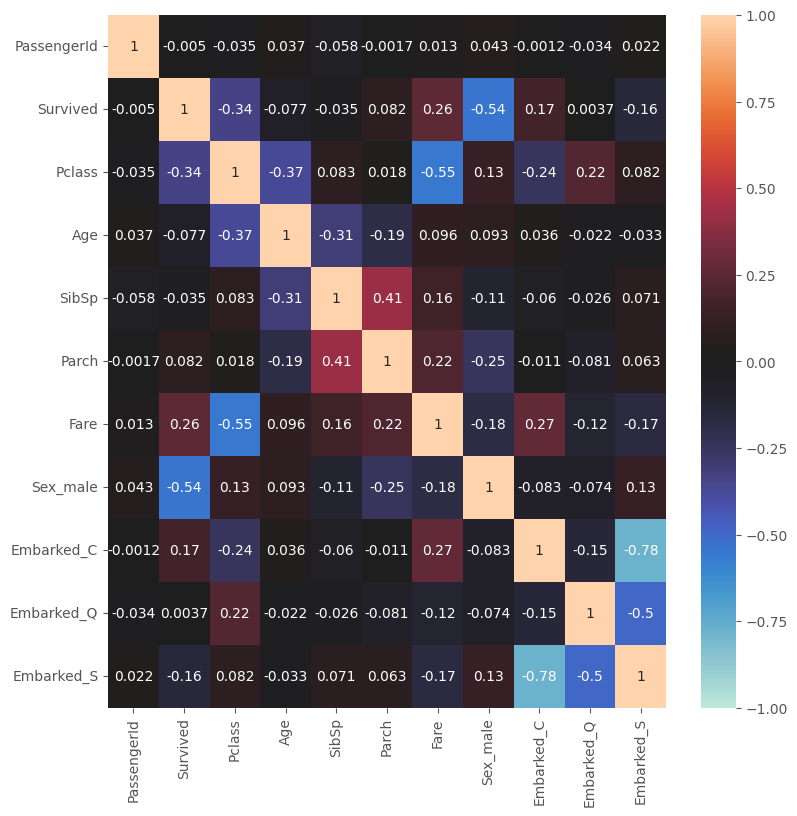

In [5]:
# =====================================================
# 더미 변수 생성 및 상관관계 분석
# =====================================================

# Sex, Embarked에 대해 더미 변수 생성
train_df_corr = pd.get_dummies(train_df, columns=["Sex"], drop_first=True)
train_df_corr = pd.get_dummies(train_df_corr, columns=["Embarked"])

# 상관관계 계산
train_corr = train_df_corr.select_dtypes(include=["number", "bool"]).corr()

# 히트맵 시각화
plt.figure(figsize=(9, 9))
sns.heatmap(train_corr, vmax=1, vmin=-1, center=0, annot=True)
plt.show()


In [6]:
# =====================================================
# 5. 데이터 전처리
# =====================================================

# (1) Train/Test 데이터 결합
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

# 결측치 확인
print(all_df.isnull().sum())

# (2) Fare 결측치 보완 (Pclass별 평균 Fare 사용)
Fare_mean = all_df.groupby("Pclass")["Fare"].mean().reset_index()
Fare_mean.columns = ["Pclass", "Fare_mean"]

# 평균 Fare 결합 후 결측치 채우기
all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
all_df.loc[all_df["Fare"].isnull(), "Fare"] = all_df["Fare_mean"]
all_df.drop("Fare_mean", axis=1, inplace=True)

# (3) Name에서 호칭 추출
name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
name_df.columns = ["family_name", "honorific", "name"]

# 공백 제거
for col in name_df.columns:
    name_df[col] = name_df[col].str.strip()

# 호칭 데이터 병합
all_df = pd.concat([all_df, name_df], axis=1)


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [7]:
# 호칭별 분포 확인
print(name_df["honorific"].value_counts())

# 호칭별 평균 나이 계산 후 결측치 채우기
honorific_age_mean = all_df.groupby("honorific")["Age"].mean().reset_index()
honorific_age_mean.columns = ["honorific", "honorific_Age"]

# 병합 및 결측치 대체
all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
all_df.loc[all_df["Age"].isnull(), "Age"] = all_df["honorific_Age"]
all_df.drop(["honorific_Age"], axis=1, inplace=True)


honorific
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64


In [8]:
# 가족 인원수(family_num)와 혼자인지 여부(alone) 생성
all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
all_df["alone"] = (all_df["family_num"] == 0).astype(int)

# 불필요한 변수 삭제
all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)


In [9]:
# 카테고리 변수 확인
categories = all_df.columns[all_df.dtypes == "object"]
print("카테고리 변수:", categories)

# honorific 정리 (Mr, Miss, Mrs, Master 외에는 'other')
all_df.loc[~all_df["honorific"].isin(["Mr", "Miss", "Mrs", "Master"]), "honorific"] = "other"

# Embarked 결측치 처리
all_df["Embarked"].fillna("missing", inplace=True)

# Label Encoding
from sklearn.preprocessing import LabelEncoder

for cat in categories:
    le = LabelEncoder()
    all_df[cat] = le.fit_transform(all_df[cat])


카테고리 변수: Index(['Sex', 'Embarked', 'honorific'], dtype='object')


/tmp/ipykernel_71/1897405506.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["Embarked"].fillna("missing", inplace=True)


In [10]:
# Train 데이터
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
train_Y = train_df["Survived"]

# Test 데이터
test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)


In [11]:
# =====================================================
# 모델 학습 (LightGBM)
# =====================================================
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Train/Validation 분할
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)

# LightGBM Dataset 생성
categories = ["Embarked", "Pclass", "Sex", "honorific", "alone"]
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)

# 기본 파라미터 설정
lgbm_params = {
    "objective": "binary",
    "random_seed": 1234
}

# 모델 학습
model_lgb = lgb.train(
    lgbm_params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_eval],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=10)
    ]
)


[LightGBM] [Info] Number of positive: 272, number of negative: 440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382022 -> initscore=-0.480973
[LightGBM] [Info] Start training from score -0.480973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

변수 중요도 시각화

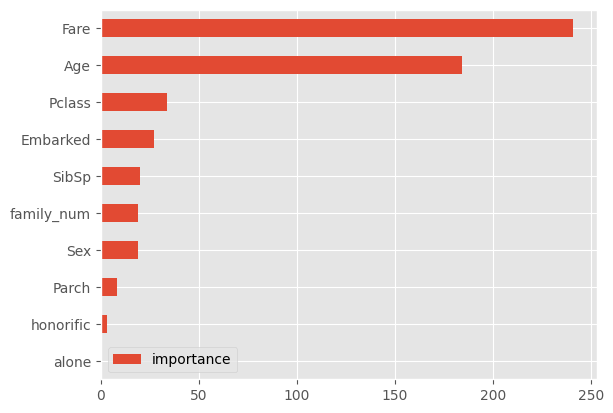

In [12]:
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=True)
importance.plot.barh()
plt.show()


In [13]:
# 예측
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

# 정확도 계산
print("Accuracy:", accuracy_score(y_valid, np.round(y_pred)))


Accuracy: 0.8435754189944135


교차검증

In [14]:
folds = 3
kf = KFold(n_splits=folds)
accuracy_list = []
models = []

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
    lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)

    model_lgb = lgb.train(
        lgbm_params,
        lgb_train,
        num_boost_round=100,
        valid_sets=[lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(period=10)
        ]
    )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    acc = accuracy_score(y_valid, np.round(y_pred))
    print("Fold accuracy:", acc)
    accuracy_list.append(acc)
    models.append(model_lgb)

print("Average Cross-Validation Accuracy:", np.mean(accuracy_list))


[LightGBM] [Info] Number of positive: 236, number of negative: 358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397306 -> initscore=-0.416701
[LightGBM] [Info] Start training from score -0.416701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [15]:
# 예측값 평균
preds = []
for model in models:
    preds.append(model.predict(test_X))

preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

# 0,1 변환
preds_int = (preds_mean > 0.5).astype(int)

# 제출 파일 생성
submission["Survived"] = preds_int
submission.to_csv("titanic_submit01.csv", index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
